In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import statsmodels.api as sm

In [2]:
#Read in bitcoin data
# bitcoin_data_df = pd.read_csv('C:/Users/Jon/Downloads/bitcoinity_data.csv')

gdp = pd.read_csv('C:/Users/Jon/Downloads/GDP (1).csv')

In [3]:
gdp['log_GDP'] = np.log(gdp['GDP'])

data = gdp[['DATE','log_GDP']].copy()
data.columns = ['DATE','Y']

In [4]:
def generate_barrier(data, inc):
    hit_df = data.copy()
    
    P = [data.loc[0,'Y']]
    N = [0]
    
    for index in data.index:
        if index > 0:
            last_index = index-1
            new_p = max(data.loc[index,'Y'], P[last_index] + inc )
            new_n = 1*(new_p == data.loc[index,'Y'])
            
            P.append(new_p)
            N.append(new_n)
    
    hit_df['P'] = P
    hit_df['hit'] = N
    hit_df['dist'] = hit_df['P'] - hit_df['Y']
    return hit_df

In [5]:
delta_mean = data['Y'].diff(1).mean()
hit_df = generate_barrier(data,delta_mean)

In [6]:
model_coef_df = pd.DataFrame(columns = ['k','const','slope','r_squared']).set_index('k')

for k in range(1,15):
    reg_df = hit_df[['dist','Y']].copy()
    reg_df['k_delta'] = reg_df['Y'].diff(k)
    reg_df['lagged_dist'] = reg_df['dist'].shift(k)
    reg_df['inv_lagged_dist'] = (reg_df['lagged_dist']+1).apply(lambda s: 1/s)
    reg_df['log_lagged_dist'] = np.log((1+reg_df['lagged_dist']))
    
    reg_df = reg_df.dropna()
    
    Y = reg_df['k_delta']
    X = sm.add_constant(reg_df['log_lagged_dist'])
    
    model = sm.OLS(Y,X).fit()
    model_coef_df.loc[k] = [model.params.values[0], model.params.values[1], model.rsquared]
    
model_coef_df

,const,slope,r_squared
k,,,
1,0.018397,-0.030520,0.101019
2,0.036480,-0.057559,0.117730
3,0.054386,-0.083101,0.124838
4,0.072116,-0.108061,0.134535
5,0.089838,-0.133608,0.146985
6,0.107650,-0.160848,0.164990
7,0.125496,-0.189072,0.183646
8,0.143500,-0.219094,0.202714
9,0.161797,-0.251783,0.222667


In [7]:
#forecast ahead
data_index = data.index
last_period = max(data_index)
k_ahead = 13

ols_k_ahead_error_df = pd.DataFrame(columns = ['k','error','sq_error'])

fitted_barrier = hit_df

for time in [x for x in data_index if x>1 and (last_period > x+k_ahead)]:
    forecast_df = fitted_barrier.loc[time:(time+k)].copy()
    
    base_y = forecast_df.loc[time,'Y']
    base_dist = forecast_df.loc[time,'dist']
    inv_base_dist = 1/(1+base_dist)
    log_base_dist = np.log(1+base_dist)
    
    for k in range(1, k_ahead):
        intercept = model_coef_df.loc[k,'const']
        slope = model_coef_df.loc[k,'slope']
        forecast_k_delta = intercept + slope * log_base_dist
        
        forecast_df.loc[time+k,'forecasted_y'] = base_y + forecast_k_delta
        
    forecast_df['error'] = forecast_df['forecasted_y'] - forecast_df['Y']
    error_vals = forecast_df.dropna()['error'].values
    
    error_df = pd.DataFrame({'k':range(1,k_ahead), 'error':error_vals})
    error_df['sq_error'] = np.square(error_df['error'])
    
    ols_k_ahead_error_df = ols_k_ahead_error_df.append(error_df) 

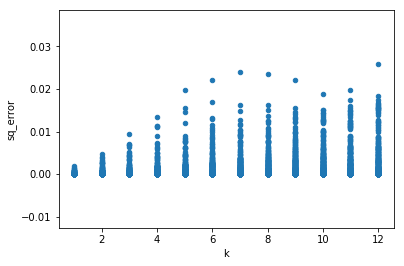

In [8]:
ols_k_ahead_error_df['k'] = ols_k_ahead_error_df['k'].astype('double')
ols_k_ahead_error_df[['k','sq_error']].plot.scatter(x='k', y='sq_error')
plt.show()

In [9]:
unit_root_errors = pd.DataFrame(columns = ['k','mean_error','mean_square_error']).set_index('k')

for k in range(1,k_ahead):
    mean_error = (data['Y'].diff(k).dropna() - k * delta_mean  ).mean() 
    mean_square_error = np.square( (data['Y'].diff(k).dropna() - k * delta_mean)   ).mean()
    unit_root_errors.loc[k] = [mean_error, mean_square_error]

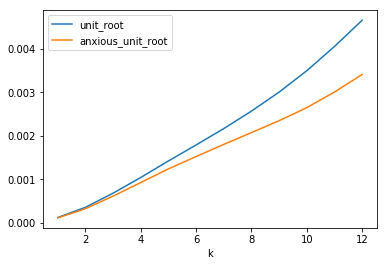

In [10]:
comparison_df = unit_root_errors[['mean_square_error']].copy()
comparison_df = comparison_df.sort_index()
comparison_df['anxious_mean_sq_error'] = ols_k_ahead_error_df[['k','sq_error']].groupby(['k']).mean().values

comparison_df.columns = ['unit_root','anxious_unit_root']
comparison_df.plot()
plt.show()